In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

from barlow_twins_loss import Custom_barlow_twins

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2023-01-31 12:08:24.316035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 12:08:24.621906: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-31 12:08:26.600358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib64:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/
2023-01-31 12:08:26.600522: W tensorflow/stream_ex

In [2]:
# Load the images, normalize and check shapes
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images/255.0
test_images = test_images/255.0

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
# Build tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(train_images)
print(dataset)

2023-01-31 12:08:31.553994: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-31 12:08:31.554103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2023-01-31 12:08:31.554132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2023-01-31 12:08:31.554375: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-01-31 12:08:31.554473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-01-31 12:08:31.554493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2023-01-31 12:08:31.556040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

<TensorSliceDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None)>


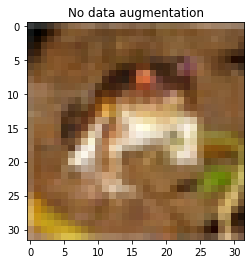

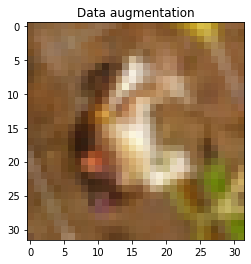

In [4]:
# Define the data augmentation techniques and apply them. Check how the images are modified
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.40)])

dataset_augmented = dataset.map(data_augmentation)

plt.imshow(dataset.take(1).get_single_element())
plt.title('No data augmentation')
plt.show()

plt.imshow(dataset_augmented.take(1).get_single_element())
plt.title('Data augmentation')
plt.show()

In [5]:
# Build a simple feature extractor model
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, kernel_size = 3, padding='same', activation='relu', input_shape=train_images[0].shape),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Conv2D(32, kernel_size = 3, padding='same', activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Flatten()])

In [6]:
# Training loop
batch_size = 512
loss_fn = Custom_barlow_twins(batch_size)
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss_fn)

loss_batch, loss_epoch = [], []

epochs = 20
for epoch in range(epochs):
    loss_list = []
    for img, augmented_img in zip(dataset.batch(batch_size), dataset_augmented.batch(batch_size)):
        with tf.GradientTape() as tape:
            z_a, z_b = model(img), model(augmented_img)
            loss = loss_fn(z_a, z_b)
            loss_list.append(loss.numpy())
        grads_model = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads_model, model.trainable_variables))
    loss_batch.extend(loss_list)
    loss_epoch.append(np.mean(loss_list))

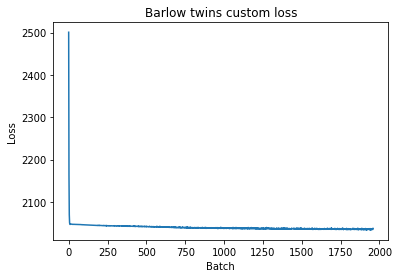

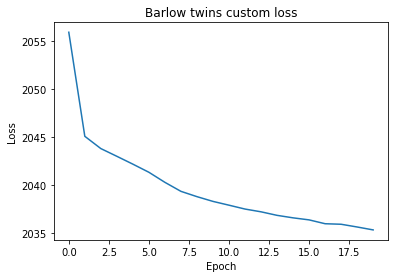

In [7]:
plt.plot(loss_batch)
plt.title('Barlow twins custom loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

plt.plot(loss_epoch)
plt.title('Barlow twins custom loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()